# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Importing librairies

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer, accuracy_score, f1_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

## Project: Weather station

<img alt="weather" src="images/map.png" width=400>

- Suppose there are 5 weather stations that monitor the weather: Paris, Brest, London, Marseille and Berlin.
- The weather station in Paris breaks down
- Can we use the other stations to infer the weather in Paris

### Data set

<img alt="weather" src="images/annual_temperature.png" width=400>

- Surface variables: skt, u10, v10, t2m, d2m, tcc, sp, tp, ssrd, blh
- Temporal resolution: hourly
- Spatial resolution: N/A

### First steps

- Look at the correlations between variables.
- What variable do I want to predict
- What time scale am interested in?
- Start with the easy predictions and move on to harder ones
- Are there events that are more predictable than others?

## Reading data : example

<Axes: xlabel='time'>

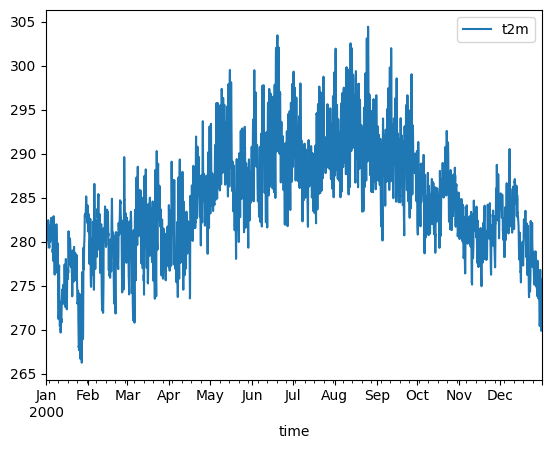

In [2]:
dir0 = Path('weather/paris/')
file_t2m = 't2m.nc'

ds = xr.open_dataset(Path(dir0, file_t2m))

# convert to pandas dataframe
df = ds.to_dataframe()

# remove latitude and longitude indices
df = df.droplevel([0,1])

df[df.index.year==2000].plot()

In [3]:
df_day = df.resample('D').mean()

## Analyse of example data

<Axes: xlabel='time'>

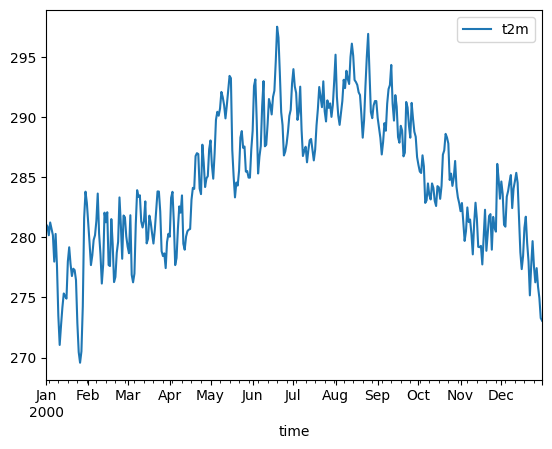

In [4]:
df_day[df_day.index.year==2000].plot()

As observed, the daily graph is smoother and free from outliers caused by factors such as sudden weather changes, sensor noise, and recording anomalies.

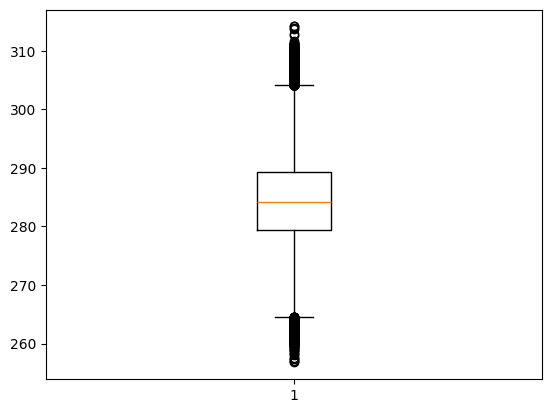

In [5]:
plt.boxplot(df)
plt.show()

In [6]:
df.describe()

t2m
count  359424.000000
mean      284.404175
std         7.122195
min       256.771332
25%       279.366875
50%       284.210266
75%       289.264053
max       314.154785

In Kelvin (K): t2m values are typically between 268 K and 308 K, with extreme heatwaves occasionally pushing temperatures beyond 313 K. Therefore, we will keep all values as they fall within this range.

Text(0.5, 0, 't2m')

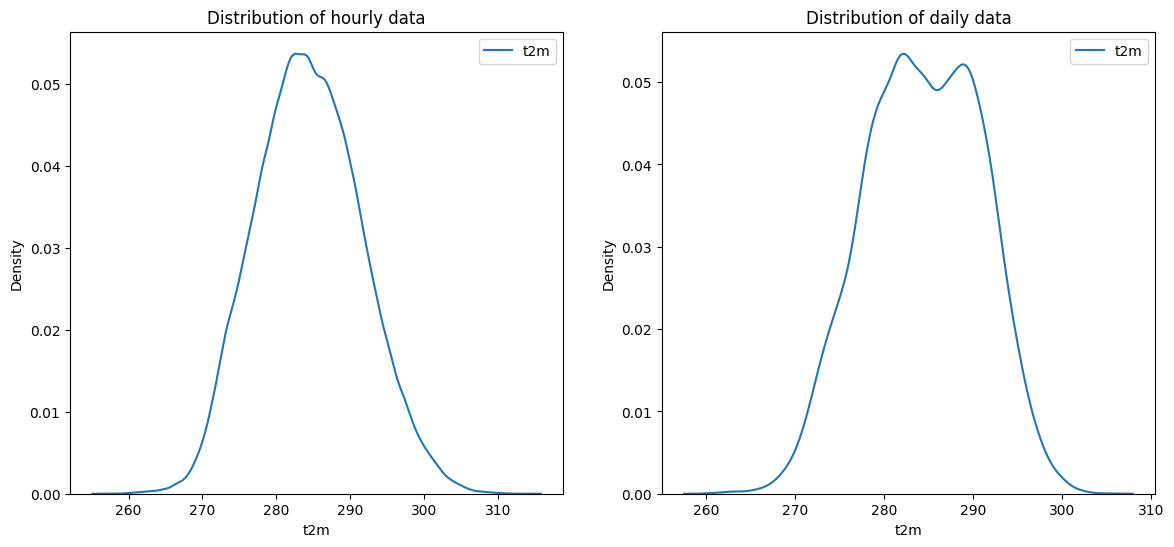

In [7]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.kdeplot(df)
plt.title('Distribution of hourly data')
plt.xlabel('t2m')
plt.subplot(1,2,2)
sns.kdeplot(df_day)
plt.title('Distribution of daily data')
plt.xlabel('t2m')

Hourly data is unimodal with a single peak, while daily data is bimodal with two peaks. This can be explained by the fact that daily aggregation captures broader trends, such as differences between warmer and cooler days. In contrast, hourly data smooths out these differences because it includes more granular fluctuations.

## Reading all data

In [8]:
from pathlib import Path
import pandas as pd
import xarray as xr

dir0 = Path('weather/')
stations = ['paris', 'brest', 'london', 'marseille', 'berlin']
variables = ['t2m', 'tp', 'skt', 'u10', 'v10', 'd2m', 'blh', 'sp', 'ssrd' , 'tcc' ]

# Function to load the data
def load_station_data(station):
    station_data = {}
    for var in variables:
        file_path = dir0 / station / f"{var}.nc"
        if file_path.exists():
            ds = xr.open_dataset(file_path)
            df = ds.to_dataframe().reset_index()
            df = df.set_index('time')
            station_data[var] = df[[var]]
    if station_data:
        common_index = pd.concat(station_data.values(), axis=0).index.unique()
        station_data_aligned = {k: v.reindex(common_index) for k, v in station_data.items()}
        merged_df = pd.concat(station_data_aligned.values(), axis=1)
        merged_df.columns = station_data.keys()
        return merged_df
    return None

# Loading the data for each station
df_paris = load_station_data('paris')
df_brest = load_station_data('brest')
df_london = load_station_data('london')
df_marseille = load_station_data('marseille')
df_berlin = load_station_data('berlin')

In [9]:
df_london.head()

t2m  tp         skt       u10       v10  \
time                                                                  
1980-01-01 00:00:00  271.648010 NaN  270.567810  2.265564 -0.946121   
1980-01-01 01:00:00  271.235352 NaN  270.226288  1.991104 -0.942688   
1980-01-01 02:00:00  270.897797 NaN  270.074280  1.819733 -0.987259   
1980-01-01 03:00:00  270.847168 NaN  269.962280  1.627426 -1.352890   
1980-01-01 04:00:00  270.771301 NaN  269.985931  1.632172 -1.340912   

                            d2m  blh             sp  ssrd       tcc  
time                                                                 
1980-01-01 00:00:00  270.848328  NaN  100375.015625   NaN  0.632019  
1980-01-01 01:00:00  270.578094  NaN  100341.843750   NaN  0.918030  
1980-01-01 02:00:00  270.341797  NaN  100334.453125   NaN  0.970001  
1980-01-01 03:00:00  270.205994  NaN  100338.320312   NaN  0.950012  
1980-01-01 04:00:00  270.110596  NaN  100308.750000   NaN  0.961792

In [10]:
df_paris.columns

Index(['t2m', 'tp', 'skt', 'u10', 'v10', 'd2m', 'blh', 'sp', 'ssrd', 'tcc'], dtype='object')

In [11]:
df_paris.describe()

t2m             tp            skt            u10  \
count  359424.000000  359424.000000  359424.000000  359424.000000   
mean      284.404175       0.000082     284.343475       0.864824   
std         7.122195       0.000297       7.731432       2.641644   
min       256.771332       0.000000     252.089996      -9.424118   
25%       279.366882       0.000000     278.848358      -1.184677   
50%       284.210266       0.000000     283.880219       0.842087   
75%       289.264038       0.000009     289.336365       2.671062   
max       314.154785       0.011550     317.110504      16.235458   

                 v10            d2m            blh             sp  \
count  359424.000000  359424.000000  359424.000000  359424.000000   
mean        0.351672     280.462677     604.306396  100415.398438   
std         2.879393       5.682072     470.669312     906.673767   
min       -10.220169     254.678604       9.829140   94526.585938   
25%        -1.833076     276.560242     205.043015   99890.281250   
50%         0.232651     280.908752     492.636017  100472.187500   
75%         2.403114     284.717285     915.939209  101001.007812   
max        14.881912     295.901764    3572.631348  103395.062500   

               ssrd            tcc  
count  3.594240e+05  359424.000000  
mean   4.776326e+05       0.664978  
std    7.350204e+05       0.369280  
min   -1.901566e+00       0.000000  
25%    0.000000e+00       0.347229  
50%    2.099200e+04       0.842072  
75%    7.504640e+05       0.998413  
max    3.315712e+06       1.000000

## inter-ville correlation

In [12]:
for c in df_paris.columns:
    df_combined = pd.concat([df_paris[c], df_brest[c], df_london[c], df_marseille[c], df_berlin[c]], axis=1)
    df_combined.columns = ['paris', 'brest', 'london', 'marseille', 'berlin']
    corr_matrix = df_combined.corr()
    print('\n')
    print(c)
    print(corr_matrix)



t2m
              paris     brest    london  marseille    berlin
paris      1.000000  0.889973  0.925401   0.880394  0.875767
brest      0.889973  1.000000  0.910519   0.837348  0.790369
london     0.925401  0.910519  1.000000   0.846232  0.849524
marseille  0.880394  0.837348  0.846232   1.000000  0.850032
berlin     0.875767  0.790369  0.849524   0.850032  1.000000


tp
              paris     brest    london  marseille    berlin
paris      1.000000  0.067990  0.133464   0.040394  0.022611
brest      0.067990  1.000000  0.149862   0.018156 -0.001081
london     0.133464  0.149862  1.000000   0.026990 -0.003144
marseille  0.040394  0.018156  0.026990   1.000000 -0.023790
berlin     0.022611 -0.001081 -0.003144  -0.023790  1.000000


skt
              paris     brest    london  marseille    berlin
paris      1.000000  0.917585  0.932248   0.876794  0.886263
brest      0.917585  1.000000  0.930056   0.878482  0.838375
london     0.932248  0.930056  1.000000   0.849066  0.866218
marseil

## intra-ville correlation

In [13]:
correlation_matrix = df_paris.corr()
correlation_matrix

t2m        tp       skt       u10       v10       d2m       blh  \
t2m   1.000000  0.020438  0.972195  0.042646  0.039966  0.866857  0.379216   
tp    0.020438  1.000000  0.015884  0.105478  0.140365  0.117461  0.059716   
skt   0.972195  0.015884  1.000000  0.015650  0.008641  0.819659  0.427805   
u10   0.042646  0.105478  0.015650  1.000000  0.339233  0.147059  0.335316   
v10   0.039966  0.140365  0.008641  0.339233  1.000000  0.143507  0.081386   
d2m   0.866857  0.117461  0.819659  0.147059  0.143507  1.000000  0.101559   
blh   0.379216  0.059716  0.427805  0.335316  0.081386  0.101559  1.000000   
sp   -0.091366 -0.262241 -0.065885 -0.231309 -0.362870 -0.156564 -0.218335   
ssrd  0.518303 -0.053044  0.645129 -0.078823 -0.096294  0.204058  0.596779   
tcc  -0.054926  0.200135 -0.049674  0.234452  0.219707  0.086632  0.117861   

            sp      ssrd       tcc  
t2m  -0.091366  0.518303 -0.054926  
tp   -0.262241 -0.053044  0.200135  
skt  -0.065885  0.645129 -0.049674  
u10  -0.231309 -0.078823  0.234452  
v10  -0.362870 -0.096294  0.219707  
d2m  -0.156564  0.204058  0.086632  
blh  -0.218335  0.596779  0.117861  
sp    1.000000  0.039054 -0.233936  
ssrd  0.039054  1.000000 -0.131210  
tcc  -0.233936 -0.131210  1.000000

## Combination of all variables into a single DataFrame, excluding Paris data, which is kept as the target.

In [14]:
# We add the city suffix to DataFrame columns
def rename_columns_with_city(df, city_name):
    return df.rename(columns=lambda col: f"{col}_{city_name}")

df_brest = rename_columns_with_city(df_brest, "brest")
df_london = rename_columns_with_city(df_london, "london")
df_marseille = rename_columns_with_city(df_marseille, "marseille")
df_berlin = rename_columns_with_city(df_berlin, "berlin")
df_paris = rename_columns_with_city(df_paris, "paris")

# We create the DataFrame : features X and target y
X = pd.concat([df_brest, df_london, df_marseille, df_berlin], axis=1)

## Handling missing values

In [15]:
X.head(8)

t2m_brest  tp_brest   skt_brest  u10_brest  v10_brest  \
time                                                                          
1980-01-01 00:00:00  278.646057       NaN  279.384216  -3.045959   3.326340   
1980-01-01 01:00:00  278.666992       NaN  279.357147  -3.187607   3.314148   
1980-01-01 02:00:00  278.604828       NaN  279.341858  -2.846283   2.434616   
1980-01-01 03:00:00  278.364746       NaN  279.268921  -3.439957   1.930313   
1980-01-01 04:00:00  278.103333       NaN  279.163666  -3.067047   1.885651   
1980-01-01 05:00:00  277.980652       NaN  279.301636  -2.951141   1.589050   
1980-01-01 06:00:00  278.023315       NaN  279.322906  -3.223007   1.684204   
1980-01-01 07:00:00  278.041107  0.000014  279.296631  -3.163635   2.215363   

                      d2m_brest  blh_brest       sp_brest  ssrd_brest  \
time                                                                    
1980-01-01 00:00:00  276.399109        NaN  100551.015625         NaN   
1980-01-01 01:00:00  276.273407        NaN  100445.843750         NaN   
1980-01-01 02:00:00  276.296875        NaN  100470.453125         NaN   
1980-01-01 03:00:00  276.332947        NaN  100415.320312         NaN   
1980-01-01 04:00:00  276.337158        NaN  100423.750000         NaN   
1980-01-01 05:00:00  276.368103        NaN  100417.359375         NaN   
1980-01-01 06:00:00  276.353668        NaN  100428.640625         NaN   
1980-01-01 07:00:00  276.414551  278.78949  100446.593750         0.0   

                     tcc_brest  ...  t2m_berlin  tp_berlin  skt_berlin  \
time                            ...                                      
1980-01-01 00:00:00   1.000000  ...  274.347229        NaN  272.974060   
1980-01-01 01:00:00   1.000000  ...  274.262695        NaN  272.786835   
1980-01-01 02:00:00   0.998413  ...  273.993500        NaN  272.630920   
1980-01-01 03:00:00   1.000000  ...  273.997559        NaN  272.440796   
1980-01-01 04:00:00   1.000000  ...  273.986145        NaN  272.105072   
1980-01-01 05:00:00   1.000000  ...  273.894714        NaN  272.522339   
1980-01-01 06:00:00   0.999207  ...  273.867065        NaN  272.360016   
1980-01-01 07:00:00   0.856323  ...  273.943451   0.000196  272.484131   

                     u10_berlin  v10_berlin  d2m_berlin  blh_berlin  \
time                                                                  
1980-01-01 00:00:00    2.986267    0.781418  273.488953         NaN   
1980-01-01 01:00:00    2.856339    0.796570  273.310516         NaN   
1980-01-01 02:00:00    2.803131    0.714890  273.041016         NaN   
1980-01-01 03:00:00    2.814926    0.733047  273.000916         NaN   
1980-01-01 04:00:00    2.795258    0.756744  273.063721         NaN   
1980-01-01 05:00:00    2.943390    0.690613  273.010681         NaN   
1980-01-01 06:00:00    3.006485    0.484985  273.074371         NaN   
1980-01-01 07:00:00    2.955505    0.085480  273.031738   502.78949   

                        sp_berlin  ssrd_berlin  tcc_berlin  
time                                                        
1980-01-01 00:00:00  99357.015625          NaN    0.916779  
1980-01-01 01:00:00  99308.843750          NaN    0.863159  
1980-01-01 02:00:00  99365.453125          NaN    0.863678  
1980-01-01 03:00:00  99363.320312          NaN    0.792236  
1980-01-01 04:00:00  99315.750000          NaN    0.832306  
1980-01-01 05:00:00  99352.359375          NaN    0.815857  
1980-01-01 06:00:00  99344.640625          NaN    0.822113  
1980-01-01 07:00:00  99360.593750          0.0    0.920044  

[8 rows x 40 columns]

In [16]:
X.isna().sum()

t2m_brest         7
tp_brest          7
skt_brest         7
u10_brest         7
v10_brest         7
d2m_brest         7
blh_brest         7
sp_brest          7
ssrd_brest        7
tcc_brest         7
t2m_london        7
tp_london         7
skt_london        7
u10_london        7
v10_london        7
d2m_london        7
blh_london        7
sp_london         7
ssrd_london       7
tcc_london        7
t2m_marseille     7
tp_marseille      7
skt_marseille     7
u10_marseille     7
v10_marseille     7
d2m_marseille     7
blh_marseille     7
sp_marseille      7
ssrd_marseille    7
tcc_marseille     7
t2m_berlin        7
tp_berlin         7
skt_berlin        7
u10_berlin        7
v10_berlin        7
d2m_berlin        7
blh_berlin        7
sp_berlin         7
ssrd_berlin       7
tcc_berlin        7
dtype: int64

In [17]:
df_paris.isna().sum()

t2m_paris     7
tp_paris      7
skt_paris     7
u10_paris     7
v10_paris     7
d2m_paris     7
blh_paris     7
sp_paris      7
ssrd_paris    7
tcc_paris     7
dtype: int64

As the number of missing values is negligible compared to the total amount of data, we will remove them.

In [18]:
X.dropna(inplace=True)
df_paris.dropna(inplace=True)

## We calculate the number of zeros in each column

### For the explanatory variables

In [19]:
# We calculate the number of zeros per column.
zeros_per_column = (X == 0).sum()

# We calculate the total number of values per column.
total_values_per_column = X.count()

# ratio of zeros per column
zero_ratio = zeros_per_column / total_values_per_column

result = pd.DataFrame({
    'Zeros Count': zeros_per_column,
    'Total Values': total_values_per_column,
    'Zero Ratio': zero_ratio
})

print(result)

                Zeros Count  Total Values  Zero Ratio
t2m_brest                 0        350633    0.000000
tp_brest             192188        350633    0.548117
skt_brest                 0        350633    0.000000
u10_brest                 0        350633    0.000000
v10_brest                 0        350633    0.000000
d2m_brest                 0        350633    0.000000
blh_brest                 0        350633    0.000000
sp_brest                  0        350633    0.000000
ssrd_brest           160066        350633    0.456506
tcc_brest             12771        350633    0.036423
t2m_london                0        350633    0.000000
tp_london            229778        350633    0.655323
skt_london                0        350633    0.000000
u10_london                1        350633    0.000003
v10_london                1        350633    0.000003
d2m_london                0        350633    0.000000
blh_london                0        350633    0.000000
sp_london                 0 

### For the target variables: Paris

In [20]:
# Same for paris
zeros_per_column_paris = (df_paris == 0).sum()

total_values_per_column_paris = df_paris.count()

zero_ratio_paris = zeros_per_column_paris / total_values_per_column_paris

result = pd.DataFrame({
    'Zeros Count': zeros_per_column_paris,
    'Total Values': total_values_per_column_paris,
    'Zero Ratio': zero_ratio_paris
})

print(result)

            Zeros Count  Total Values  Zero Ratio
t2m_paris             0        359417    0.000000
tp_paris         236982        359417    0.659351
skt_paris             0        359417    0.000000
u10_paris             1        359417    0.000003
v10_paris             0        359417    0.000000
d2m_paris             0        359417    0.000000
blh_paris             0        359417    0.000000
sp_paris              0        359417    0.000000
ssrd_paris       164634        359417    0.458058
tcc_paris         24548        359417    0.068299


## Detecting whether there are outliers

In [21]:
for c in X.columns:
    print(c)
    print(X[c].describe())

t2m_brest
count    350633.000000
mean        285.042267
std           4.206890
min         266.545654
25%         282.226990
50%         284.986023
75%         288.057617
max         304.947449
Name: t2m_brest, dtype: float64
tp_brest
count    350633.000000
mean          0.000104
std           0.000320
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000053
max           0.009577
Name: tp_brest, dtype: float64
skt_brest
count    350633.000000
mean        285.286835
std           4.394971
min         268.572327
25%         282.132355
50%         284.920105
75%         288.187988
max         305.868896
Name: skt_brest, dtype: float64
u10_brest
count    350633.000000
mean          1.326230
std           4.228701
min         -11.726608
25%          -1.889145
50%           1.374191
75%           4.275879
max          21.111069
Name: u10_brest, dtype: float64
v10_brest
count    350633.000000
mean          0.247948
std           4.248537
min         -15.397

t2m is typically between 268 K and 313 K.
tp is typically between 0 mm and 50 mm (per day).
skt is typically between 270 K and 320 K.
u10 and v10 are typically between  -20 m/s and 20 m/s.
d2m  is typically between 250 K and 300 K
blh is typically between 0 m and 3,000 m.
sp is typically between  950 hPa and 1050 hPa
ssrd is typically between 0 W/m² and 1,000 W/m².
tcc is typically between 0 and 1

##### Thus, we conclude that all values are normal, and there are no outliers.

## Daily Data

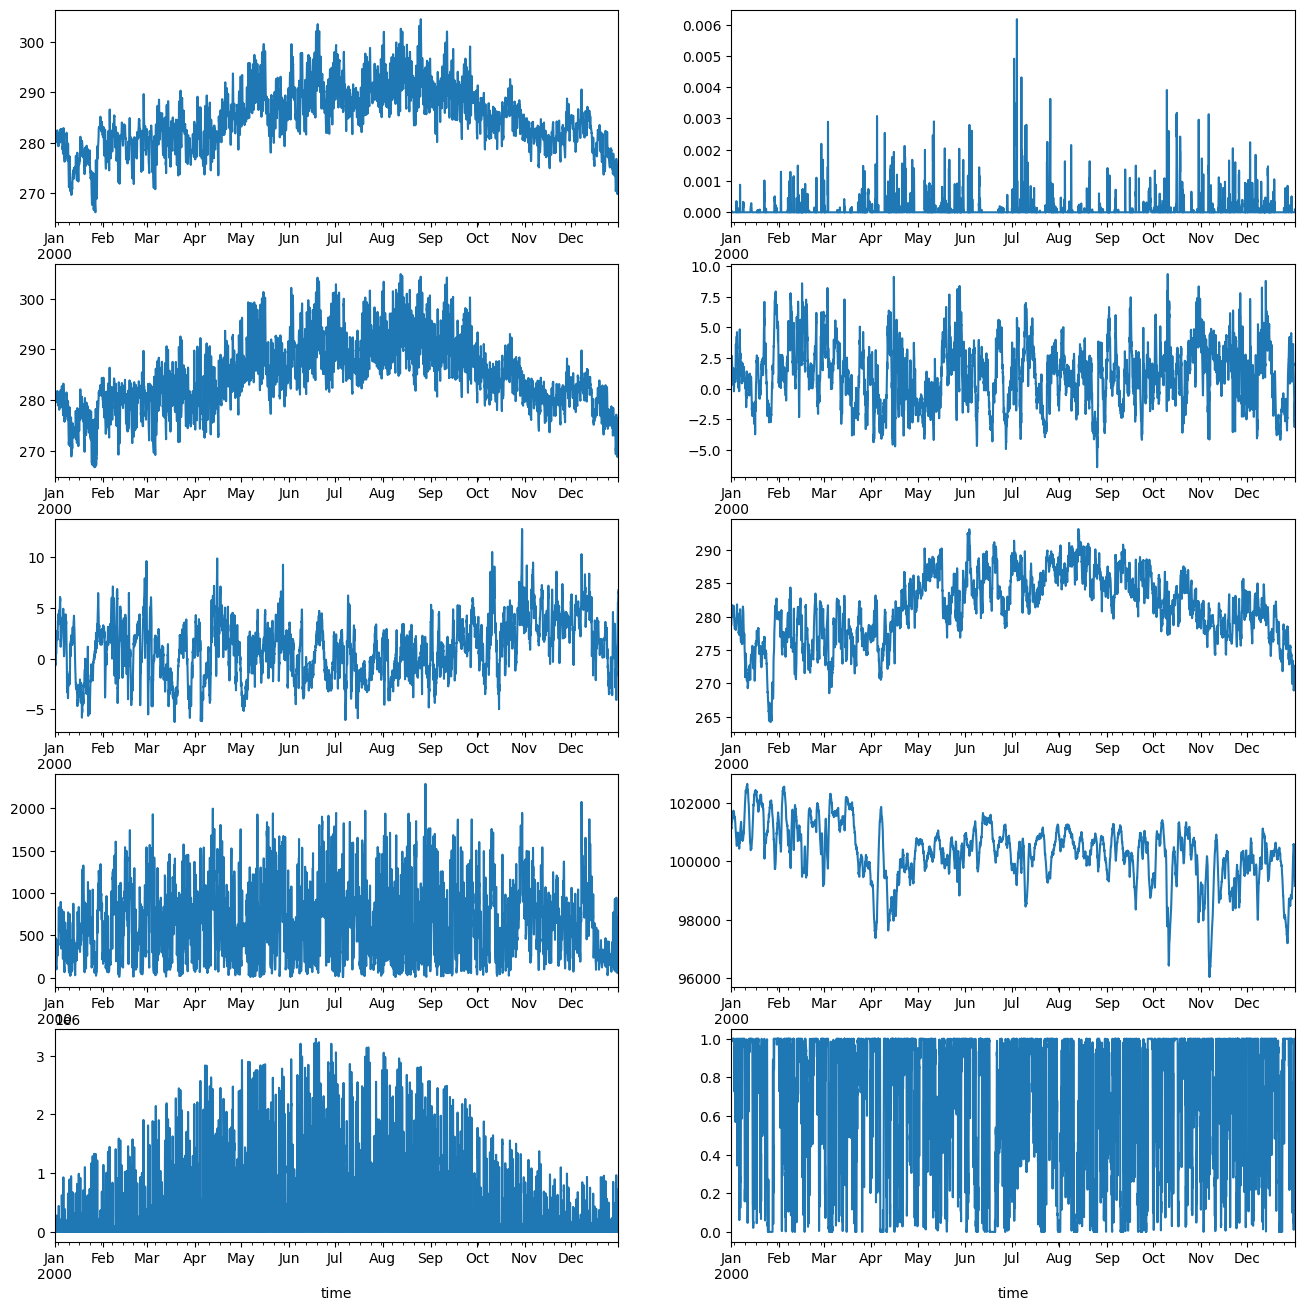

In [22]:
plt.figure(figsize=(16,16))
for i, c in enumerate(df_paris.columns):
    plt.subplot(5,2,i+1)
    df_paris[c][df_paris[c].index.year==2000].plot()

As observed, there are many fluctuations caused by variations, particularly the sudden changes that occur during certain hours of the day. 

Those fluctuations and noise observed in the hourly data make it challenging to analyze trends effectively. This is why we aggregate the data into daily intervals to smooth out the variations and focus on broader patterns.

### To obtain smoother data, we aggregate it into daily data.

In [23]:
X.columns

Index(['t2m_brest', 'tp_brest', 'skt_brest', 'u10_brest', 'v10_brest',
       'd2m_brest', 'blh_brest', 'sp_brest', 'ssrd_brest', 'tcc_brest',
       't2m_london', 'tp_london', 'skt_london', 'u10_london', 'v10_london',
       'd2m_london', 'blh_london', 'sp_london', 'ssrd_london', 'tcc_london',
       't2m_marseille', 'tp_marseille', 'skt_marseille', 'u10_marseille',
       'v10_marseille', 'd2m_marseille', 'blh_marseille', 'sp_marseille',
       'ssrd_marseille', 'tcc_marseille', 't2m_berlin', 'tp_berlin',
       'skt_berlin', 'u10_berlin', 'v10_berlin', 'd2m_berlin', 'blh_berlin',
       'sp_berlin', 'ssrd_berlin', 'tcc_berlin'],
      dtype='object')

In [24]:
df_paris_day = df_paris.resample('D').mean()
X_day = X.resample('D').mean()

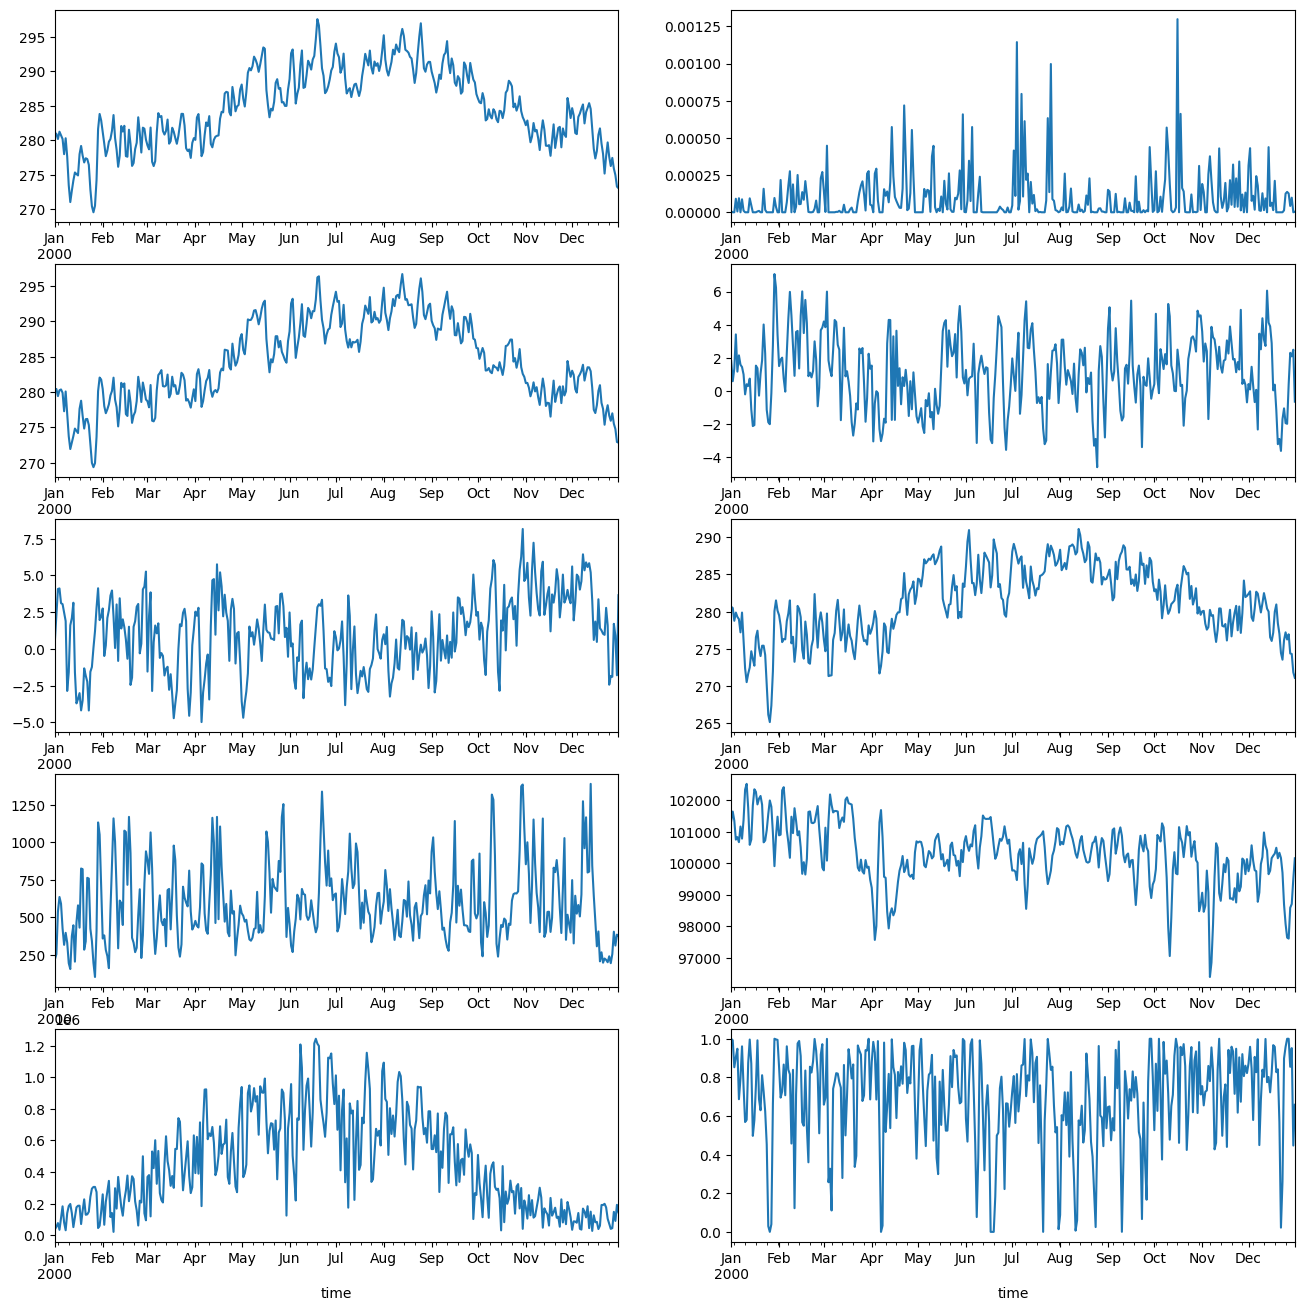

In [25]:
plt.figure(figsize=(16,16))
for i, c in enumerate(df_paris_day.columns):
    plt.subplot(5,2,i+1)
    df_paris_day[c][df_paris_day[c].index.year==2000].plot()

### Data distribution for each variable, in hourly and daily cases.

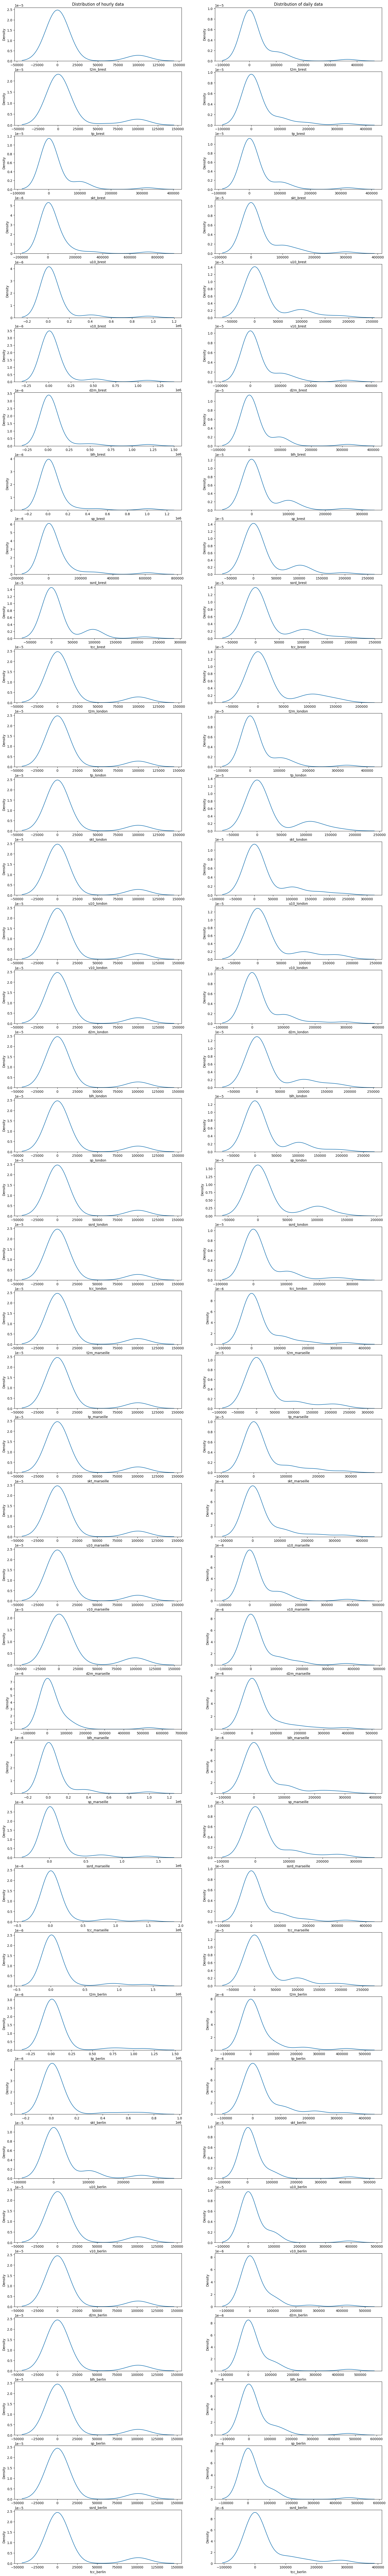

In [26]:
plt.figure(figsize=(20,140))
plt.subplot(X.shape[1],2,1)
sns.kdeplot(X.iloc[0])
plt.title('Distribution of hourly data')
plt.xlabel(X.columns[0])
plt.subplot(X.shape[1],2,2)
sns.kdeplot(X_day.iloc[0])
plt.xlabel(X.columns[0])
plt.title('Distribution of daily data')
j=3
for i in range (1, X.shape[1]): 
    plt.subplot(X.shape[1],2,j)
    sns.kdeplot(X.iloc[i])
    plt.xlabel(X.columns[i])
    plt.subplot(X.shape[1],2,j+1)
    sns.kdeplot(X_day.iloc[i])
    plt.xlabel(X.columns[i])
    j=j+2

As seen in almost all variables, in the hourly case, there are some extreme values caused by fluctuations during certain hours. 

Aggregation eliminates those extreme values, making the data more stable and efficient for capturing the average across one day.

## modelling

In [27]:
X_day = X_day
Y_day = df_paris_day

# We align X_day and Y_day.
X_aligned, Y_aligned = X_day.align(Y_day, join='inner', axis=0)

# Dividing into en train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.2, random_state=42)

# Multi-output linear regression model.
model = LinearRegression()
model.fit(X_train, Y_train)

# Predictions
Y_pred = model.predict(X_test)

# Evaluation per variable
rmse_values = {}
r2_values = {}

for i, var in enumerate(variables):
    rmse_val = root_mean_squared_error(Y_test[var + "_paris"], Y_pred[:, i])
    r2_val = r2_score(Y_test[var + "_paris"], Y_pred[:, i])
    rmse_values[var] = rmse_val
    r2_values[var] = r2_val
    print(f"{var}: RMSE={rmse_val}, R2={r2_val}")


t2m: RMSE=1.453710675239563, R2=0.9475359320640564
tp: RMSE=0.00011906698637176305, R2=0.31156688928604126
skt: RMSE=1.4275093078613281, R2=0.9534925818443298
u10: RMSE=0.6649025678634644, R2=0.9237604141235352
v10: RMSE=0.9225059151649475, R2=0.8746284246444702
d2m: RMSE=1.6029547452926636, R2=0.9126265645027161
blh: RMSE=157.04563903808594, R2=0.6579979658126831
sp: RMSE=84.52340698242188, R2=0.9907315373420715
ssrd: RMSE=141551.421875, R2=0.8019895553588867
tcc: RMSE=0.2000482976436615, R2=0.48631083965301514


We can see that linear regression performs very well on 6 of the 10 variables to be predicted, so we'll see if it's possible to reduce the number of features used to speed up the program without too great a degradation in performance on 6 variables. For each variable, we will use the top ten variables it depends on. The number 10 was chosen after testing different values between 1 and 40 (the total number of variables), and ten was found to be the most appropriate. 

For the other 4 variables, we got resonable performance for ssrd, but there is still room for improvement. Blh and tcc showed moderate generalization with acceptable RMSE values considering the scale of the variables. 

However, for tp, the RMSE was very low, but the generalization was poor due to the highly imbalanced distribution and the significant proportion of zero values.

### Predicting u10

In [28]:
y_u10 = df_paris_day['u10_paris']  #'u10' as target

In [29]:
X_day.shape , y_u10.shape

((14610, 40), (14976,))

In [30]:
X_cleaned, y_u10_cleaned = X_day.align(y_u10, join='inner', axis=0)
print(X_cleaned.shape)
print(y_u10_cleaned.shape)

(14610, 40)
(14610,)


In [31]:
correlations_selected_u10 = X_cleaned.corrwith(y_u10_cleaned).sort_values(ascending=False)
print("Variables most correlated with u10_paris:")
print(correlations_selected_u10.head(10))

Variables most correlated with u10_paris:
u10_brest        0.833033
u10_london       0.831725
v10_berlin       0.528005
blh_brest        0.526864
u10_marseille    0.502751
blh_london       0.500670
tp_berlin        0.340884
u10_berlin       0.336452
tcc_berlin       0.270101
tcc_brest        0.258532
dtype: float64


In [32]:
selected_features_u10 = correlations_selected_u10.head(10).index
X_selected_u10 = X_cleaned[selected_features_u10]
y_u10_selected = y_u10_cleaned
X_train_u10, X_test_u10, y_train_u10, y_test_u10 = train_test_split(X_selected_u10, y_u10_selected, test_size=0.2, random_state=42)
model_u10 = LinearRegression()
model_u10.fit(X_train_u10, y_train_u10)
y_pred_u10_train = model_u10.predict(X_train_u10)
y_pred_u10 = model_u10.predict(X_test_u10)

rmse_u10_train = root_mean_squared_error(y_train_u10, y_pred_u10_train)
r2_u10_train = r2_score(y_train_u10, y_pred_u10_train)

rmse_u10 = root_mean_squared_error(y_test_u10, y_pred_u10)
r2_u10 = r2_score(y_test_u10, y_pred_u10)

print(f"RMSE_train: {rmse_u10_train}")
print(f"R2_train: {r2_u10_train}")

print(f"RMSE: {rmse_u10}")
print(f"R2: {r2_u10}")

RMSE_train: 0.9244897365570068
R2_train: 0.8471964001655579
RMSE: 0.918505072593689
R2: 0.8545118570327759


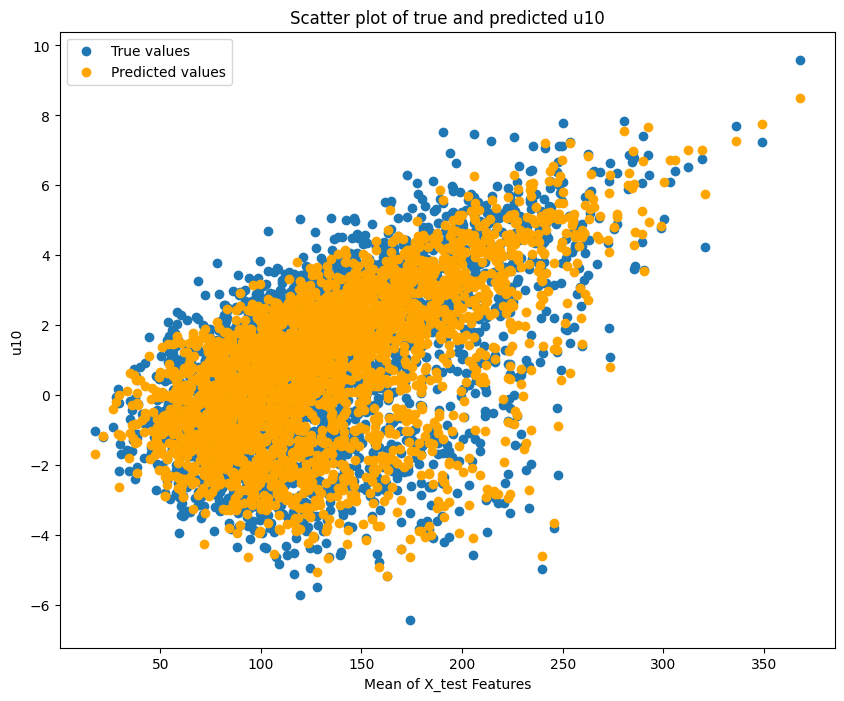

In [33]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_u10.mean(axis=1), y_test_u10, label='True values')
plt.scatter(X_test_u10.mean(axis=1), y_pred_u10, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted u10')
plt.ylabel('u10')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

Now, let's use a cross-validation approach.

In [34]:
model_u10_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_rmse_scores = cross_val_score(
    model_u10_cv,
    X_train_u10,
    y_train_u10,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_u10_cv,
    X_train_u10,
    y_train_u10,
    scoring='r2',
    cv=cv
)

# We calculate the mean and the standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_u10 = root_mean_squared_error(y_test_u10, y_pred_u10)
r2_u10 = r2_score(y_test_u10, y_pred_u10)

print(f"RMSE: {rmse_u10}")
print(f"R2: {r2_u10}")

Cross-validated RMSE: 0.9257 ± 0.0164
Cross-validated R²: 0.8466 ± 0.0063
RMSE: 0.918505072593689
R2: 0.8545118570327759


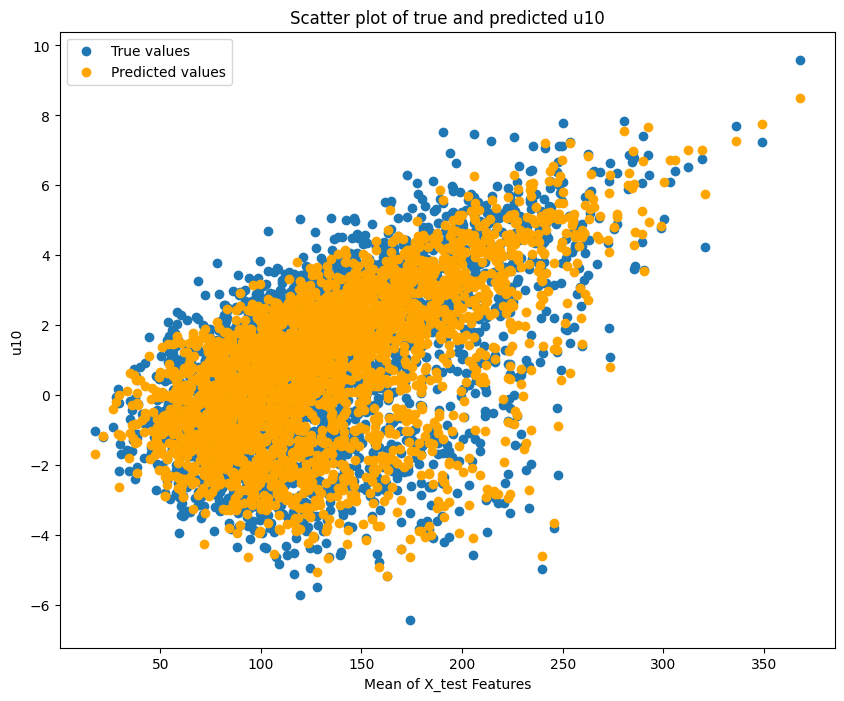

In [35]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_u10.mean(axis=1), y_test_u10, label='True values')
plt.scatter(X_test_u10.mean(axis=1), y_pred_u10, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted u10')
plt.ylabel('u10')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

We obtained close values, which indicates the model's consistency and robustness.

Now we repeat everything we did with the variable u10 for the other variables.

### Predicting v10

In [36]:
y_v10 = df_paris_day['v10_paris']  # 'v10' as target

In [37]:
X_day.shape , y_v10.shape

((14610, 40), (14976,))

In [38]:
X_cleaned, y_v10_cleaned = X_day.align(y_v10, join='inner', axis=0)
print(X_cleaned.shape)
print(y_v10_cleaned.shape)

(14610, 40)
(14610,)


In [39]:
correlations_selected_v10 = X_cleaned.corrwith(y_v10_cleaned).sort_values(ascending=False)
print("Variables most correlated with v10_paris:")
print(correlations_selected_v10.head(10))

Variables most correlated with v10_paris:
v10_london    0.755780
v10_brest     0.656717
u10_brest     0.650680
v10_berlin    0.650227
tp_brest      0.515498
tp_london     0.465317
tcc_brest     0.390910
blh_brest     0.348437
u10_london    0.319132
tcc_london    0.310578
dtype: float64


In [40]:
selected_features_v10 = correlations_selected_v10.head(10).index
X_selected_v10 = X_cleaned[selected_features_v10]
y_v10_selected = y_v10_cleaned
X_train_v10, X_test_v10, y_train_v10, y_test_v10 = train_test_split(X_selected_v10, y_v10_selected, test_size=0.2, random_state=42)

model_v10 = LinearRegression()
model_v10.fit(X_train_v10, y_train_v10)

y_pred_v10_train = model_v10.predict(X_train_v10)
y_pred_v10 = model_v10.predict(X_test_v10)

rmse_v10_train = root_mean_squared_error(y_train_v10, y_pred_v10_train)
r2_v10_train = r2_score(y_train_v10, y_pred_v10_train)

rmse_v10 = root_mean_squared_error(y_test_v10, y_pred_v10)
r2_v10 = r2_score(y_test_v10, y_pred_v10)

print(f"RMSE_train: {rmse_v10_train}")
print(f"R2_train: {r2_v10_train}")

print(f"RMSE: {rmse_v10}")
print(f"R2: {r2_v10}")

RMSE_train: 1.1083258390426636
R2_train: 0.8170495629310608
RMSE: 1.1185390949249268
R2: 0.8156839609146118


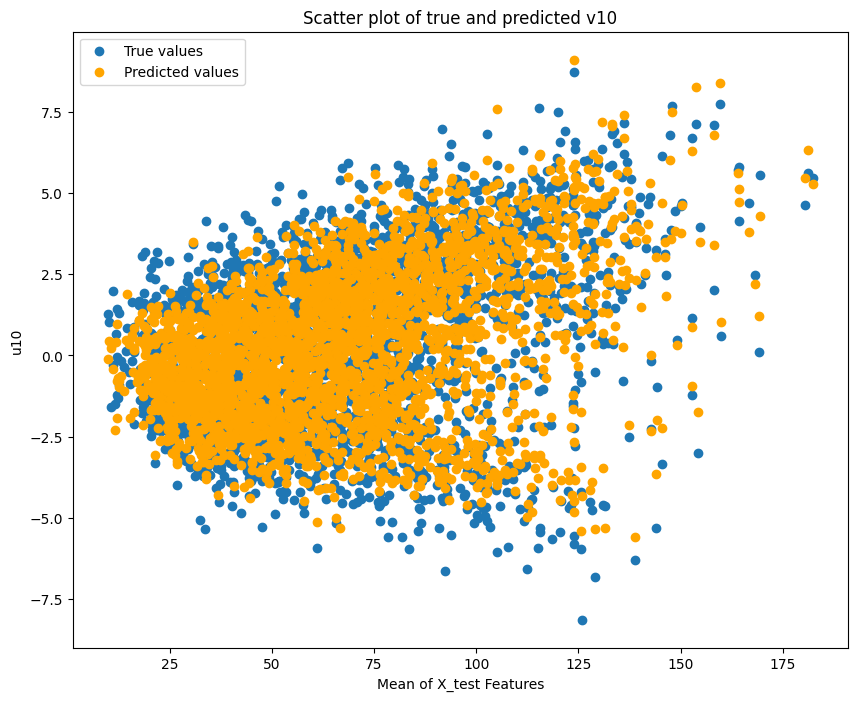

In [41]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_v10.mean(axis=1), y_test_v10, label='True values')
plt.scatter(X_test_v10.mean(axis=1), y_pred_v10, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted v10')
plt.ylabel('u10')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [42]:
model_v10_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_v10_cv,
    X_train_v10,
    y_train_v10,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_v10_cv,
    X_train_v10,
    y_train_v10,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_v10 = root_mean_squared_error(y_test_v10, y_pred_v10)
r2_v10 = r2_score(y_test_v10, y_pred_v10)

print(f"RMSE: {rmse_v10}")
print(f"R2: {r2_v10}")

Cross-validated RMSE: 1.1098 ± 0.0132
Cross-validated R²: 0.8165 ± 0.0043
RMSE: 1.1185390949249268
R2: 0.8156839609146118


### Predicting t2m

In [43]:
y_t2m = df_paris_day['t2m_paris']  #'t2m' as target

In [44]:
X_day.shape , y_t2m.shape

((14610, 40), (14976,))

In [45]:
X_cleaned, y_t2m_cleaned = X_day.align(y_t2m, join='inner', axis=0)
print(X_cleaned.shape)
print(y_t2m_cleaned.shape)

(14610, 40)
(14610,)


In [46]:
correlations_selected_t2m = X_cleaned.corrwith(y_t2m_cleaned).sort_values(ascending=False)
print("Variables most correlated with t2m_paris:")
print(correlations_selected_t2m.head(10))

Variables most correlated with t2m_paris:
skt_london       0.948663
t2m_london       0.946323
skt_brest        0.926436
t2m_brest        0.914815
t2m_marseille    0.906723
skt_berlin       0.905506
t2m_berlin       0.901263
skt_marseille    0.882933
d2m_london       0.880480
d2m_brest        0.869518
dtype: float64


In [47]:
selected_features_t2m = correlations_selected_t2m.head(10).index
X_selected_t2m = X_cleaned[selected_features_t2m]
y_t2m_selected = y_t2m_cleaned
X_train_t2m, X_test_t2m, y_train_t2m, y_test_t2m = train_test_split(X_selected_t2m, y_t2m_selected, test_size=0.2, random_state=42)

model_t2m = LinearRegression()
model_t2m.fit(X_train_t2m, y_train_t2m)

y_pred_t2m_train = model_t2m.predict(X_train_t2m)
y_pred_t2m = model_t2m.predict(X_test_t2m)

rmse_t2m_train = root_mean_squared_error(y_train_t2m, y_pred_t2m_train)
r2_t2m_train = r2_score(y_train_t2m, y_pred_t2m_train)

rmse_t2m = root_mean_squared_error(y_test_t2m, y_pred_t2m)
r2_t2m = r2_score(y_test_t2m, y_pred_t2m)

print(f"RMSE_train: {rmse_t2m_train}")
print(f"R2_train: {r2_t2m_train}")

print(f"RMSE: {rmse_t2m}")
print(f"R2: {r2_t2m}")

RMSE_train: 1.644766092300415
R2_train: 0.936392605304718
RMSE: 1.6131398677825928
R2: 0.9353973865509033


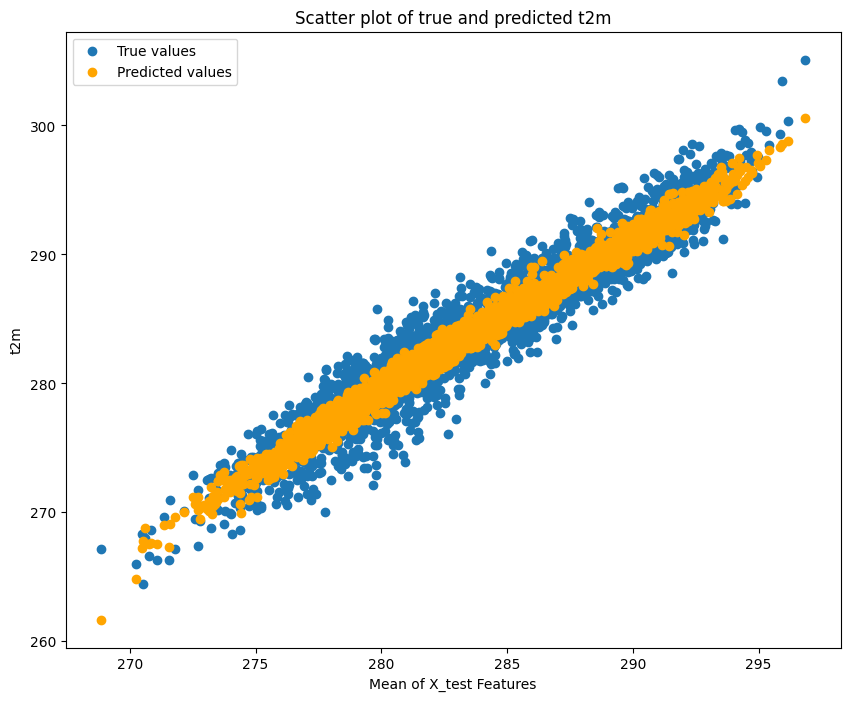

In [48]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_t2m.mean(axis=1), y_test_t2m, label='True values')
plt.scatter(X_test_t2m.mean(axis=1), y_pred_t2m, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted t2m')
plt.ylabel('t2m')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [49]:
model_t2m_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_t2m_cv,
    X_train_t2m,
    y_train_t2m,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_t2m_cv,
    X_train_t2m,
    y_train_t2m,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_t2m = root_mean_squared_error(y_test_t2m, y_pred_t2m)
r2_t2m = r2_score(y_test_t2m, y_pred_t2m)

print(f"RMSE: {rmse_t2m}")
print(f"R2: {r2_t2m}")

Cross-validated RMSE: 1.6470 ± 0.0139
Cross-validated R²: 0.9362 ± 0.0011
RMSE: 1.6131398677825928
R2: 0.9353973865509033


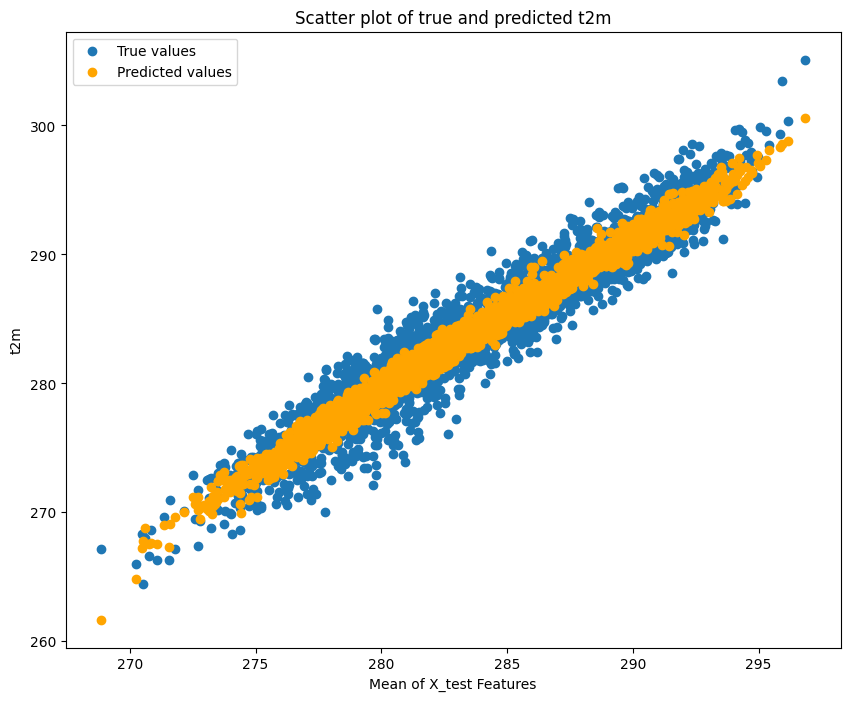

In [50]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_t2m.mean(axis=1), y_test_t2m, label='True values')
plt.scatter(X_test_t2m.mean(axis=1), y_pred_t2m, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted t2m')
plt.ylabel('t2m')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

### Predicting d2m

In [51]:
y_d2m = df_paris_day['d2m_paris']  #'d2m' as target

In [52]:
X_day.shape , y_d2m.shape

((14610, 40), (14976,))

In [53]:
X_cleaned, y_d2m_cleaned = X_day.align(y_d2m, join='inner', axis=0)
print(X_cleaned.shape)
print(y_d2m_cleaned.shape)

(14610, 40)
(14610,)


In [54]:
correlations_selected_d2m = X_cleaned.corrwith(y_d2m_cleaned).sort_values(ascending=False)
print("Variables most correlated with d2m_paris:")
print(correlations_selected_d2m.head(10))

Variables most correlated with d2m_paris:
d2m_london       0.899240
d2m_brest        0.890039
t2m_london       0.888421
skt_london       0.881112
t2m_brest        0.877276
skt_brest        0.870049
t2m_berlin       0.847960
skt_berlin       0.845692
t2m_marseille    0.838234
d2m_berlin       0.829190
dtype: float64


In [55]:
selected_features_d2m = correlations_selected_d2m.head(10).index
X_selected_d2m = X_cleaned[selected_features_d2m]
y_d2m_selected = y_d2m_cleaned
X_train_d2m, X_test_d2m, y_train_d2m, y_test_d2m = train_test_split(X_selected_d2m, y_d2m_selected, test_size=0.2, random_state=42)

model_d2m = LinearRegression()
model_d2m.fit(X_train_d2m, y_train_d2m)

y_pred_d2m_train = model_d2m.predict(X_train_d2m)
y_pred_d2m = model_d2m.predict(X_test_d2m)

rmse_d2m_train = root_mean_squared_error(y_train_d2m, y_pred_d2m_train)
r2_d2m_train = r2_score(y_train_d2m, y_pred_d2m_train)

rmse_d2m = root_mean_squared_error(y_test_d2m, y_pred_d2m)
r2_d2m = r2_score(y_test_d2m, y_pred_d2m)

print(f"RMSE_train: {rmse_d2m_train}")
print(f"R2_train: {r2_d2m_train}")

print(f"RMSE: {rmse_d2m}")
print(f"R2: {r2_d2m}")

RMSE_train: 1.887865662574768
R2_train: 0.8838224411010742
RMSE: 1.8641153573989868
R2: 0.8818367123603821


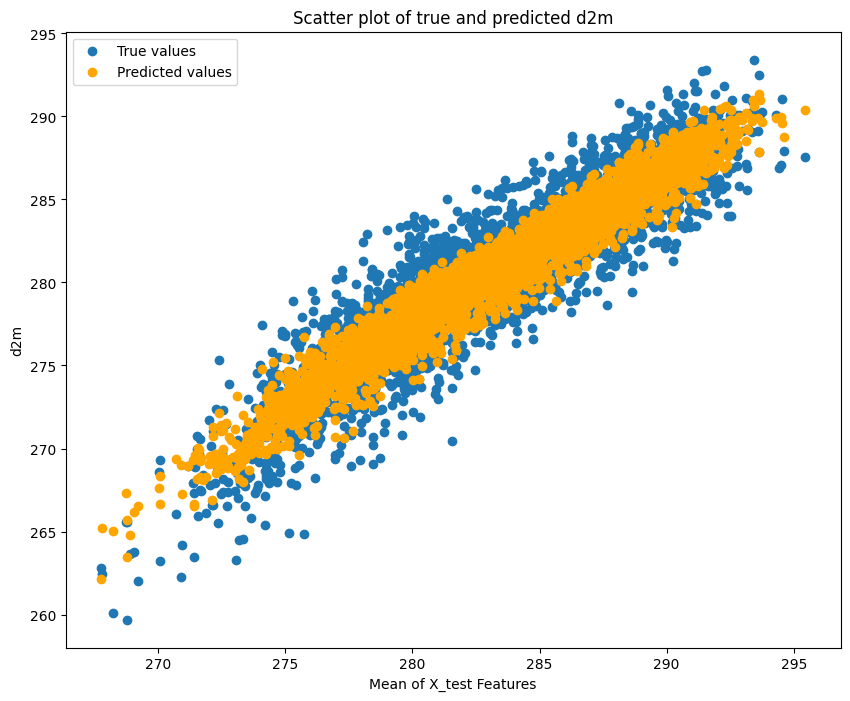

In [56]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_d2m.mean(axis=1), y_test_d2m, label='True values')
plt.scatter(X_test_d2m.mean(axis=1), y_pred_d2m, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted d2m')
plt.ylabel('d2m')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [57]:
model_d2m_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_d2m_cv,
    X_train_d2m,
    y_train_d2m,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_d2m_cv,
    X_train_d2m,
    y_train_d2m,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_d2m = root_mean_squared_error(y_test_d2m, y_pred_d2m)
r2_d2m = r2_score(y_test_d2m, y_pred_d2m)

print(f"RMSE: {rmse_d2m}")
print(f"R2: {r2_d2m}")

Cross-validated RMSE: 1.8896 ± 0.0176
Cross-validated R²: 0.8836 ± 0.0023
RMSE: 1.8641153573989868
R2: 0.8818367123603821


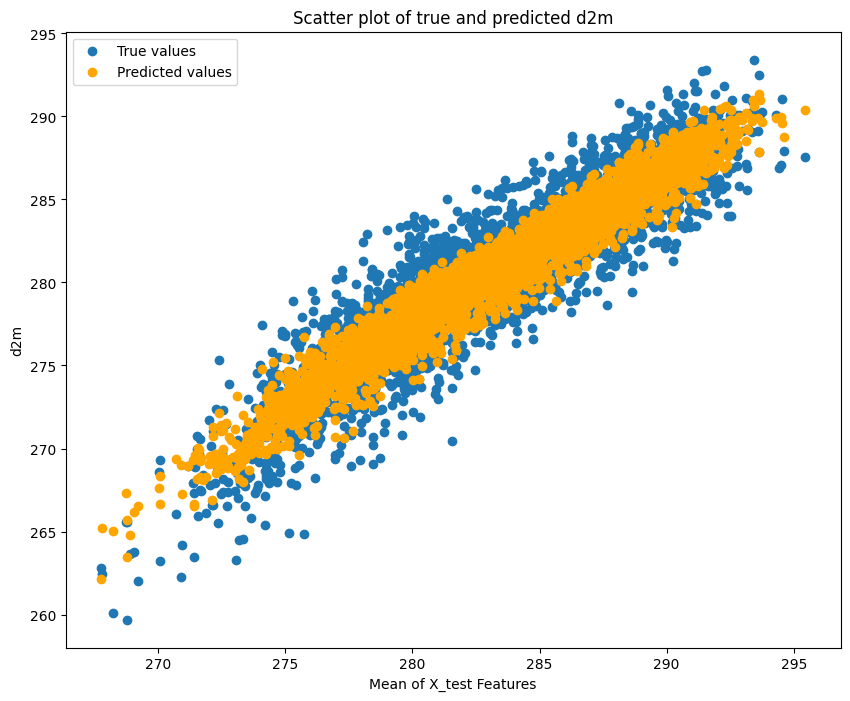

In [58]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_d2m.mean(axis=1), y_test_d2m, label='True values')
plt.scatter(X_test_d2m.mean(axis=1), y_pred_d2m, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted d2m')
plt.ylabel('d2m')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

### Predicting skt

In [59]:
y_skt = df_paris_day['skt_paris']  #'skt' as target

In [60]:
X_day.shape , y_skt.shape

((14610, 40), (14976,))

In [61]:
X_cleaned, y_skt_cleaned = X_day.align(y_skt, join='inner', axis=0)
print(X_cleaned.shape)
print(y_skt_cleaned.shape)

(14610, 40)
(14610,)


In [62]:
correlations_selected_skt = X_cleaned.corrwith(y_skt_cleaned).sort_values(ascending=False)
print("Variables most correlated with skt_paris:")
print(correlations_selected_skt.head(10))

Variables most correlated with skt_paris:
skt_london       0.954457
t2m_london       0.946102
skt_brest        0.935574
t2m_marseille    0.921357
skt_berlin       0.915564
t2m_brest        0.913325
t2m_berlin       0.907171
skt_marseille    0.903640
d2m_london       0.873152
d2m_brest        0.861536
dtype: float64


In [63]:
selected_features_skt = correlations_selected_skt.head(10).index
X_selected_skt = X_cleaned[selected_features_skt]
y_skt_selected = y_skt_cleaned
X_train_skt, X_test_skt, y_train_skt, y_test_skt = train_test_split(X_selected_skt, y_skt_selected, test_size=0.2, random_state=42)

model_skt = LinearRegression()
model_skt.fit(X_train_skt, y_train_skt)

y_pred_skt_train = model_skt.predict(X_train_skt)
y_pred_skt = model_skt.predict(X_test_skt)

rmse_skt_train = root_mean_squared_error(y_train_skt, y_pred_skt_train)
r2_skt_train = r2_score(y_train_skt, y_pred_skt_train)

rmse_skt = root_mean_squared_error(y_test_skt, y_pred_skt)
r2_skt = r2_score(y_test_skt, y_pred_skt)

print(f"RMSE_train: {rmse_skt_train}")
print(f"R2_train: {r2_skt_train}")

print(f"RMSE: {rmse_skt}")
print(f"R2: {r2_skt}")

RMSE_train: 1.5930579900741577
R2_train: 0.9450036883354187
RMSE: 1.5558346509933472
R2: 0.9447551965713501


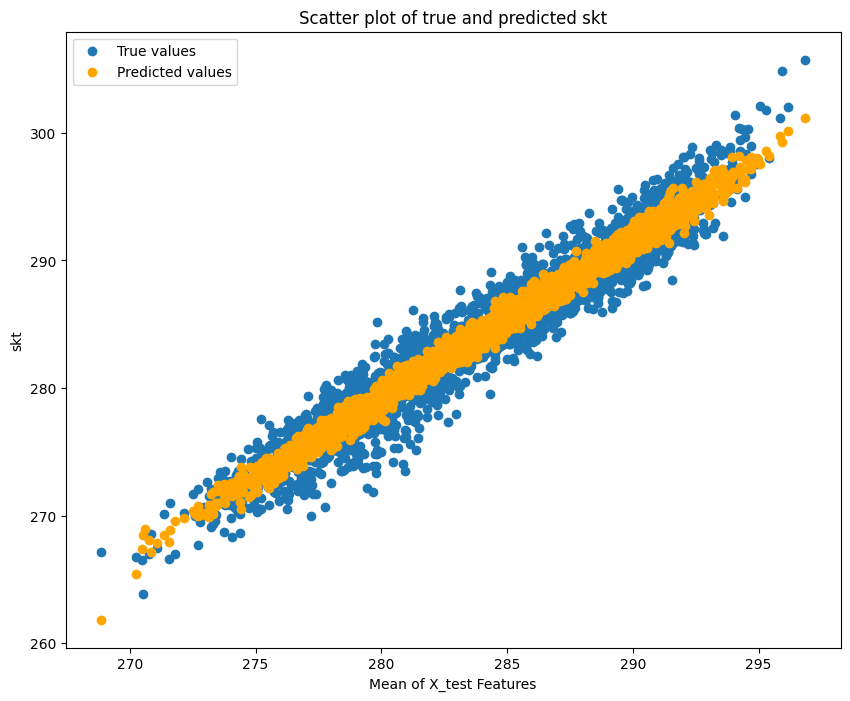

In [64]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_skt.mean(axis=1), y_test_skt, label='True values')
plt.scatter(X_test_skt.mean(axis=1), y_pred_skt, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted skt')
plt.ylabel('skt')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [65]:
model_skt_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_skt_cv,
    X_train_skt,
    y_train_skt,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_skt_cv,
    X_train_skt,
    y_train_skt,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_skt = root_mean_squared_error(y_test_skt, y_pred_skt)
r2_skt = r2_score(y_test_skt, y_pred_skt)

print(f"RMSE: {rmse_skt}")
print(f"R2: {r2_skt}")

Cross-validated RMSE: 1.5949 ± 0.0178
Cross-validated R²: 0.9448 ± 0.0011
RMSE: 1.5558346509933472
R2: 0.9447551965713501


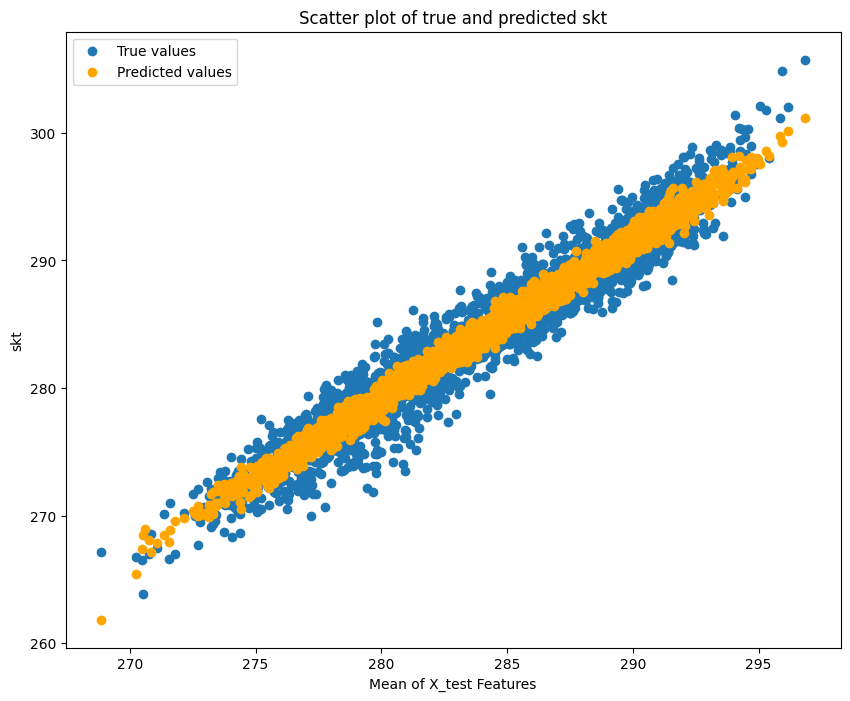

In [66]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_skt.mean(axis=1), y_test_skt, label='True values')
plt.scatter(X_test_skt.mean(axis=1), y_pred_skt, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted skt')
plt.ylabel('skt')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

### predicting sp

In [67]:
y_sp = df_paris_day['sp_paris']  #'sp' as target

In [68]:
X_day.shape , y_sp.shape

((14610, 40), (14976,))

In [69]:
X_cleaned, y_sp_cleaned = X_day.align(y_sp, join='inner', axis=0)
print(X_cleaned.shape)
print(y_sp_cleaned.shape)

(14610, 40)
(14610,)


In [70]:
correlations_selected_sp = X_cleaned.corrwith(y_sp_cleaned).sort_values(ascending=False)
print("Variables most correlated with sp_paris:")
print(correlations_selected_sp.head(10))

Variables most correlated with sp_paris:
sp_brest          0.927659
sp_london         0.923764
sp_berlin         0.727092
sp_marseille      0.572915
u10_berlin        0.338996
blh_berlin        0.080628
ssrd_marseille    0.080332
u10_marseille     0.041604
u10_london        0.040902
ssrd_brest        0.036843
dtype: float64


In [71]:
selected_features_sp = correlations_selected_sp.head(10).index
X_selected_sp = X_cleaned[selected_features_sp]
y_sp_selected = y_sp_cleaned
X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(X_selected_sp, y_sp_selected, test_size=0.2, random_state=42)

model_sp = LinearRegression()
model_sp.fit(X_train_sp, y_train_sp)

y_pred_sp_train = model_sp.predict(X_train_sp)
y_pred_sp = model_sp.predict(X_test_sp)

rmse_sp_train = root_mean_squared_error(y_train_sp, y_pred_sp_train)
r2_sp_train = r2_score(y_train_sp, y_pred_sp_train)

rmse_sp = root_mean_squared_error(y_test_sp, y_pred_sp)
r2_sp = r2_score(y_test_sp, y_pred_sp)

print(f"RMSE_train: {rmse_sp_train}")
print(f"R2_train: {r2_sp_train}")

print(f"RMSE: {rmse_sp}")
print(f"R2: {r2_sp}")

RMSE_train: 131.6868438720703
R2_train: 0.9775598049163818
RMSE: 130.41798400878906
R2: 0.9779337644577026


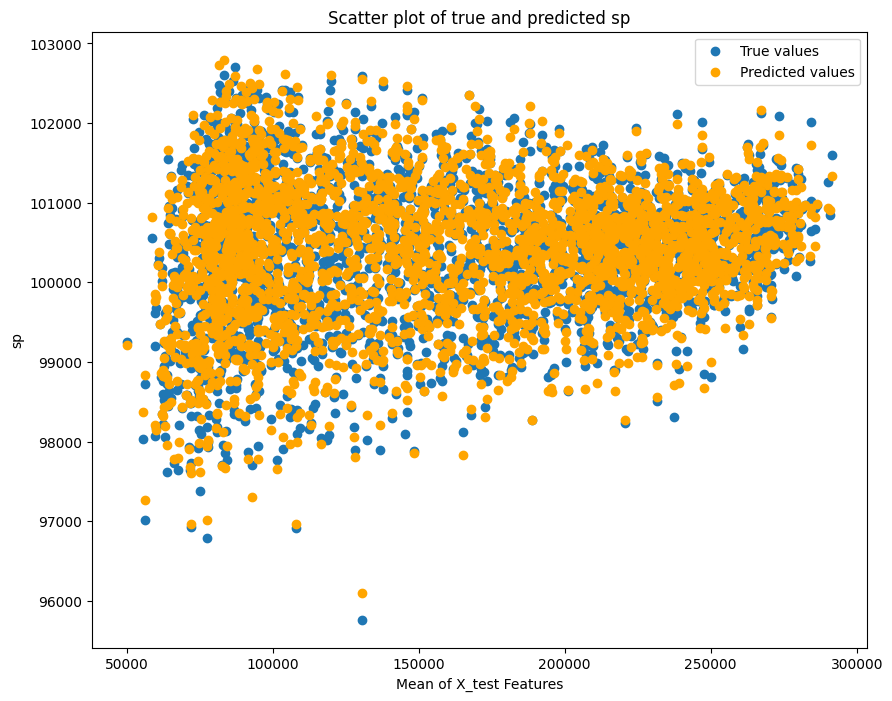

In [72]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_sp.mean(axis=1), y_test_sp, label='True values')
plt.scatter(X_test_sp.mean(axis=1), y_pred_sp, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted sp')
plt.ylabel('sp')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

In [73]:
model_sp_cv = LinearRegression()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_rmse_scores = cross_val_score(
    model_sp_cv,
    X_train_sp,
    y_train_sp,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

r2_scores = cross_val_score(
    model_sp_cv,
    X_train_sp,
    y_train_sp,
    scoring='r2',
    cv=cv
)

# Calculate mean and standard deviation for RMSE and R²
mean_rmse = -np.mean(neg_rmse_scores)
std_rmse = np.std(neg_rmse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Cross-validated RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"Cross-validated R²: {mean_r2:.4f} ± {std_r2:.4f}")

rmse_sp = root_mean_squared_error(y_test_sp, y_pred_sp)
r2_sp = r2_score(y_test_sp, y_pred_sp)

print(f"RMSE: {rmse_sp}")
print(f"R2: {r2_sp}")

Cross-validated RMSE: 131.8033 ± 1.2858
Cross-validated R²: 0.9775 ± 0.0008
RMSE: 130.41798400878906
R2: 0.9779337644577026


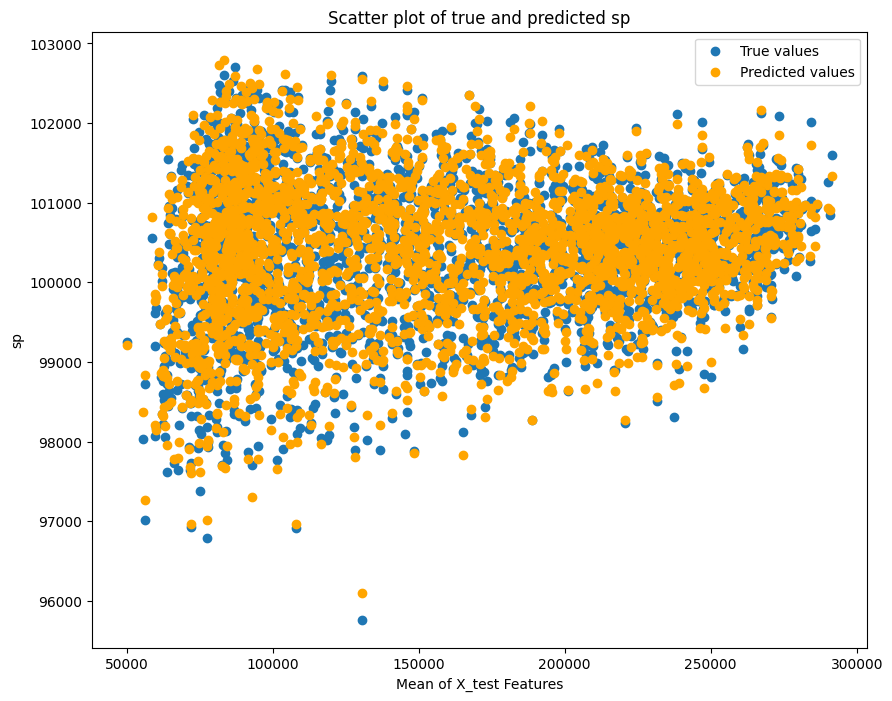

In [74]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_sp.mean(axis=1), y_test_sp, label='True values')
plt.scatter(X_test_sp.mean(axis=1), y_pred_sp, label='Predicted values', c='orange')
plt.title('Scatter plot of true and predicted sp')
plt.ylabel('sp')
plt.xlabel('Mean of X_test Features')
plt.legend()
plt.show()

##### Now, let's focus on the other four variables: ssrd, blh, tcc, and tp.

## Improve performances

At the beginning, we used GridSearchCV with several models, each tested with multiple variables. We observed that XGBoostRegressor was the most performant model, but the GridSearchCV process was very time-consuming. Therefore, we switched to RandomizedSearchCV with XGBoostRegressor and achieved almost the same results with a significantly shorter execution time compared to GridSearchCV.

In [75]:
# RandomizedSearchCV parameters
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Number of iterations and number of folds RandomizedSearchCV
n_iter_search = 20
cv_folds = 3

### predicting ssrd

In [76]:
# Target variable
var = 'ssrd_paris'

# Training initial model
initial_model_ssrd = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
initial_model_ssrd.fit(X_train, Y_train[var])

# Initial predictions
preds_initial_ssrd = initial_model_ssrd.predict(X_test)

# Initiale evaluation
rmse_init_ssrd = root_mean_squared_error(Y_test[var], preds_initial_ssrd)
r2_init_ssrd = r2_score(Y_test[var], preds_initial_ssrd)
print(f"{var} - Initial: RMSE={rmse_init_ssrd:.4f}, R²={r2_init_ssrd:.4f}")

# Optimisation of hyperparameters
search_ssrd = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',
    cv=cv_folds,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
search_ssrd.fit(X_train, Y_train[var])

# Best model
best_model_ssrd = search_ssrd.best_estimator_
best_model_ssrd.fit(X_train, Y_train[var])

# Otimized predictions
preds_best_ssrd = best_model_ssrd.predict(X_test)

# Evaluation
rmse_best_ssrd = root_mean_squared_error(Y_test[var], preds_best_ssrd)
r2_best_ssrd = r2_score(Y_test[var], preds_best_ssrd)
print(f"{var} - Optimisé: RMSE={rmse_best_ssrd:.4f}, R²={r2_best_ssrd:.4f}")
print(f"Meilleurs paramètres : {search_ssrd.best_params_}")

ssrd_paris - Initial: RMSE=129670.4375, R²=0.8338
ssrd_paris - Optimisé: RMSE=127029.6719, R²=0.8405
Meilleurs paramètres : {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


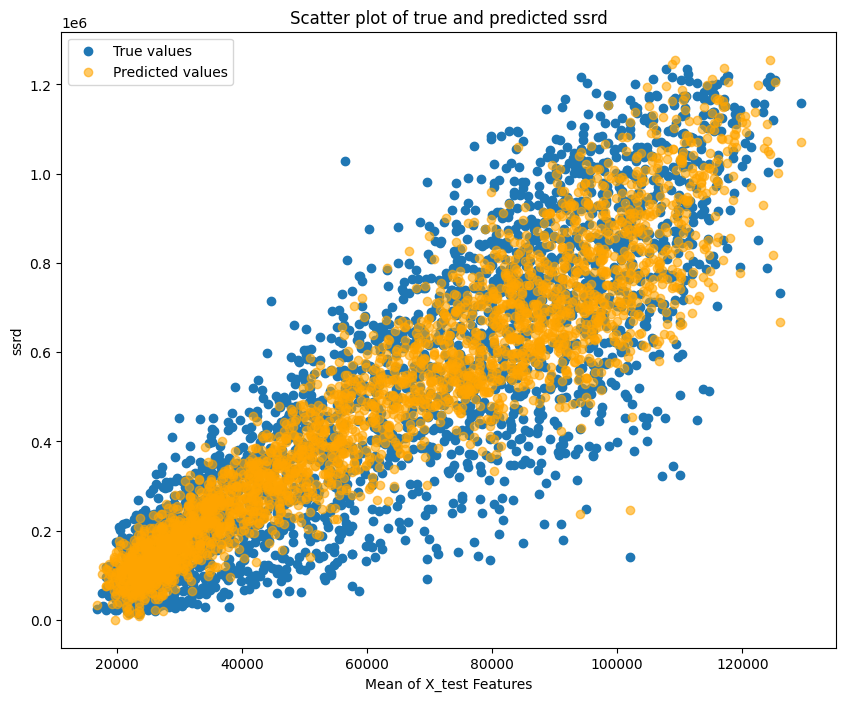

In [77]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test.mean(axis=1), Y_test[var], label='True values')
plt.scatter(X_test.mean(axis=1), preds_best_ssrd, label='Predicted values', c='orange', alpha=0.6)
plt.title('Scatter plot of true and predicted ssrd')
plt.xlabel('Mean of X_test Features')
plt.ylabel('ssrd')
plt.legend()
plt.show()

As seen, we obtain strong performance for the ssrd model, with a reasonable RMSE considering the scale of the variable, and good consistency, demonstrating good generalization.

### predicting blh

In [78]:
var = 'blh_paris'

initial_model_blh = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
initial_model_blh.fit(X_train, Y_train[var])

preds_initial_blh = initial_model_blh.predict(X_test)

rmse_init_blh = root_mean_squared_error(Y_test[var], preds_initial_blh)
r2_init_blh = r2_score(Y_test[var], preds_initial_blh)
print(f"{var} - Initial: RMSE={rmse_init_blh:.4f}, R²={r2_init_blh:.4f}")

search_blh = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',
    cv=cv_folds,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
search_blh.fit(X_train, Y_train[var])

best_model_blh = search_blh.best_estimator_
best_model_blh.fit(X_train, Y_train[var])

preds_best_blh = best_model_blh.predict(X_test)

rmse_best_blh = root_mean_squared_error(Y_test[var], preds_best_blh)
r2_best_blh = r2_score(Y_test[var], preds_best_blh)
print(f"{var} - Optimisé: RMSE={rmse_best_blh:.4f}, R²={r2_best_blh:.4f}")
print(f"Meilleurs paramètres : {search_blh.best_params_}")

blh_paris - Initial: RMSE=129.2960, R²=0.7682
blh_paris - Optimisé: RMSE=123.4067, R²=0.7888
Meilleurs paramètres : {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


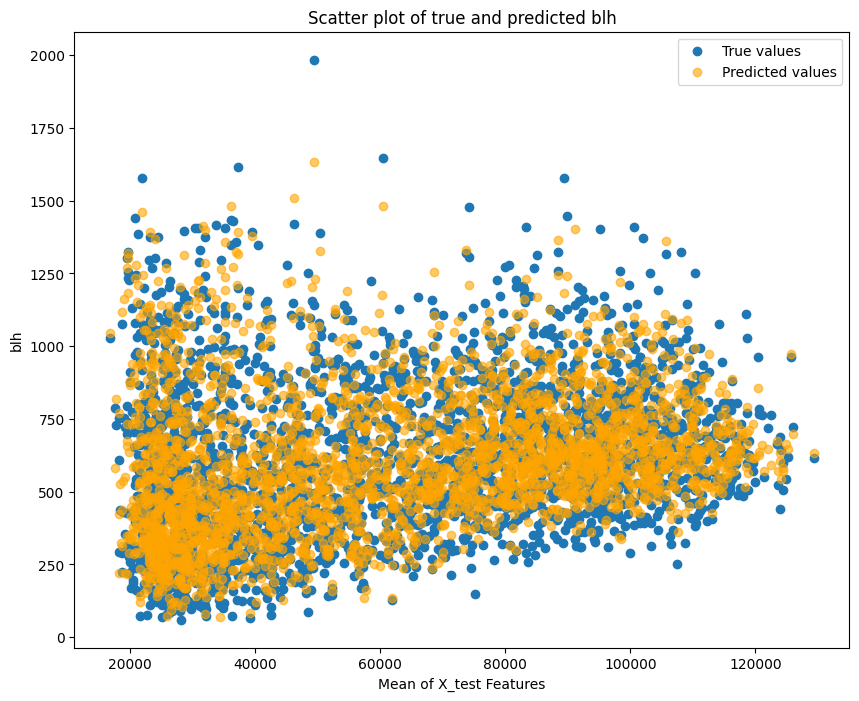

In [79]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test.mean(axis=1), Y_test[var], label='True values')
plt.scatter(X_test.mean(axis=1), preds_best_blh, label='Predicted values', c='orange', alpha=0.6)
plt.title('Scatter plot of true and predicted blh')
plt.xlabel('Mean of X_test Features')
plt.ylabel('blh')
plt.legend()
plt.show()

We achieved an RMSE reduction of approximately 30 and an improvement of 0.13 compared to linear regression.

Good performance, with a reasonable RMSE considering the scale of the variable, and good consistency, demonstrating good generalization.

### Predicting tcc

In [80]:
var = 'tcc_paris'

initial_model_tcc = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
initial_model_tcc.fit(X_train, Y_train[var])

preds_initial_tcc = initial_model_tcc.predict(X_test)

rmse_init_tcc = root_mean_squared_error(Y_test[var], preds_initial_tcc)
r2_init_tcc = r2_score(Y_test[var], preds_initial_tcc)
print(f"{var} - Initial: RMSE={rmse_init_tcc:.4f}, R²={r2_init_tcc:.4f}")

search_tcc = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',
    cv=cv_folds,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
search_tcc.fit(X_train, Y_train[var])

best_model_tcc = search_tcc.best_estimator_
best_model_tcc.fit(X_train, Y_train[var])

preds_best_tcc = best_model_tcc.predict(X_test)
rmse_best_tcc = root_mean_squared_error(Y_test[var], preds_best_tcc)
r2_best_tcc = r2_score(Y_test[var], preds_best_tcc)
print(f"{var} - Optimisé: RMSE={rmse_best_tcc:.4f}, R²={r2_best_tcc:.4f}")
print(f"Meilleurs paramètres : {search_tcc.best_params_}")

tcc_paris - Initial: RMSE=0.1882, R²=0.5453
tcc_paris - Optimisé: RMSE=0.1856, R²=0.5579
Meilleurs paramètres : {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


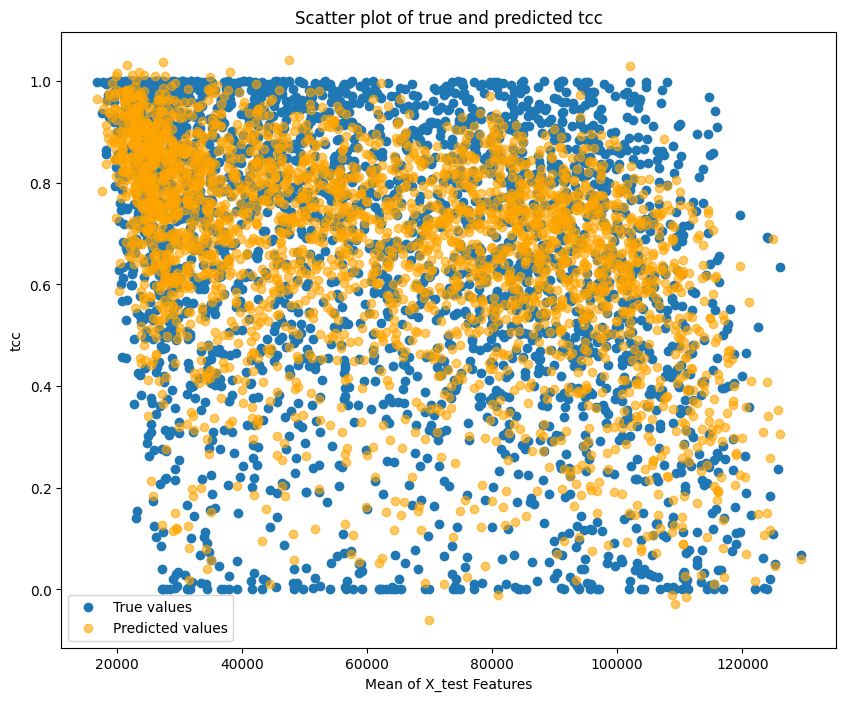

In [81]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test.mean(axis=1), Y_test[var], label='True values')
plt.scatter(X_test.mean(axis=1), preds_best_tcc, label='Predicted values', c='orange', alpha=0.6)
plt.title('Scatter plot of true and predicted tcc')
plt.xlabel('Mean of X_test Features')
plt.ylabel('tcc')
plt.legend()
plt.show()

The performance is not strong, it is moderate, but better than linear regression, which serves as our baseline model.

### Predicting tp

In [82]:
var = 'tp_paris'

initial_model_tp = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
initial_model_tp.fit(X_train, Y_train[var])

preds_initial_tp = initial_model_tp.predict(X_test)

rmse_init_tp = root_mean_squared_error(Y_test[var], preds_initial_tp)
r2_init_tp = r2_score(Y_test[var], preds_initial_tp)
print(f"{var} - Initial: RMSE={rmse_init_tp:.4f}, R²={r2_init_tp:.4f}")

search_tp = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='neg_mean_squared_error',
    cv=cv_folds,
    verbose=0,
    random_state=42,
    n_jobs=-1
)
search_tp.fit(X_train, Y_train[var])

best_model_tp = search_tp.best_estimator_
best_model_tp.fit(X_train, Y_train[var])

preds_best_tp = best_model_tp.predict(X_test)

rmse_best_tp = root_mean_squared_error(Y_test[var], preds_best_tp)
r2_best_tp = r2_score(Y_test[var], preds_best_tp)
print(f"{var} - Optimisé: RMSE={rmse_best_tp:.4f}, R²={r2_best_tp:.4f}")
print(f"Meilleurs paramètres : {search_tp.best_params_}")

tp_paris - Initial: RMSE=0.0001, R²=0.3208
tp_paris - Optimisé: RMSE=0.0001, R²=0.3262
Meilleurs paramètres : {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


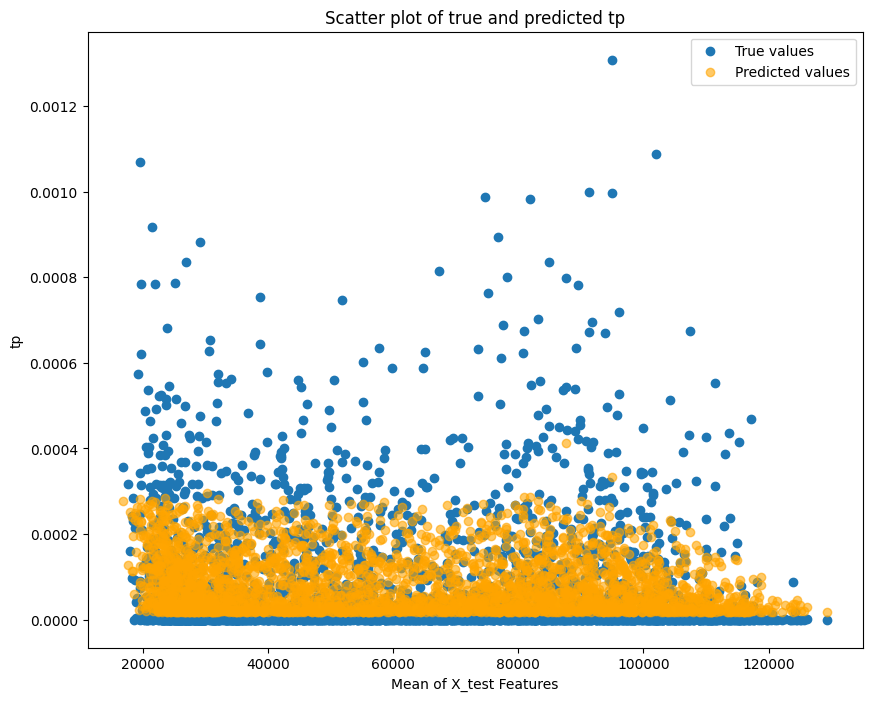

In [83]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test.mean(axis=1), Y_test[var], label='True values')
plt.scatter(X_test.mean(axis=1), preds_best_tp, label='Predicted values', c='orange', alpha=0.6)
plt.title('Scatter plot of true and predicted tp')
plt.xlabel('Mean of X_test Features')
plt.ylabel('tp')
plt.legend()
plt.show()

Poor performances again for tp!

##### Solution: Using two sequential models:
            First model: A binary classification to predict whether precipitation occurs or not.
            Second model: A regression on data where precipitation values are strictly positive, to accurately predict the value of tp.

In [84]:
print(df_paris_day['tp_paris'].describe())
print(df_paris_day['tp_paris'].head())


count    14976.000000
mean         0.000082
std          0.000147
min          0.000000
25%          0.000000
50%          0.000014
75%          0.000097
max          0.001421
Name: tp_paris, dtype: float64
time
1980-01-01    5.245209e-06
1980-01-02    5.761783e-07
1980-01-03    1.157920e-04
1980-01-04    1.973510e-04
1980-01-05    2.326568e-05
Freq: D, Name: tp_paris, dtype: float32


In [85]:
zeros_per_column_paris_day = (df_paris_day == 0).sum()

total_values_per_column_paris_day = df_paris_day.count()

zero_ratio_paris_day = zeros_per_column_paris_day / total_values_per_column_paris_day

result = pd.DataFrame({
    'Zeros Count': zeros_per_column_paris_day,
    'Total Values': total_values_per_column_paris_day,
    'Zero Ratio': zero_ratio_paris_day
})

print(result)

            Zeros Count  Total Values  Zero Ratio
t2m_paris             0         14976    0.000000
tp_paris           4093         14976    0.273304
skt_paris             0         14976    0.000000
u10_paris             0         14976    0.000000
v10_paris             0         14976    0.000000
d2m_paris             0         14976    0.000000
blh_paris             0         14976    0.000000
sp_paris              0         14976    0.000000
ssrd_paris            0         14976    0.000000
tcc_paris           153         14976    0.010216


In [86]:
# Create binary target for classification (1 if precipitation > 0, else 0)
Y_aligned['tp_paris_binary'] = (Y_aligned['tp_paris'] > 0).astype(int)

# Split data for the classification task
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X_aligned, Y_aligned['tp_paris_binary'], test_size=0.2, random_state=42
)

# Classification model: Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train_class)
y_pred_class = clf.predict(X_test)

print("Classification Accuracy:", accuracy_score(y_test_class, y_pred_class))

Classification Accuracy: 0.8323066392881588


In [88]:
# Identify indices where the model predicts rain
rain_indices = X_test.index[y_pred_class == 1]
no_rain_indices = X_test.index[y_pred_class == 0]

# Initialize final predictions with 0 for no-rain cases
y_pred_final = pd.Series(0, index=X_test.index)

# Perform regression only on cases where the classifier predicts rain
X_test_reg = X_test.loc[rain_indices]
y_test_reg = Y_aligned.loc[rain_indices, 'tp_paris']

# Regression model: Random Forest Regressor
non_zero = Y_aligned[Y_aligned['tp_paris'] > 0]
X_reg = X_aligned.loc[non_zero.index]
y_reg = non_zero['tp_paris']

X_train_reg, _, y_train_reg, _ = train_test_split(
X_reg, y_reg, test_size=0.2, random_state=42)

reg = RandomForestRegressor()
reg.fit(X_train_reg, y_train_reg)

# Predict for rain cases
y_pred_reg = reg.predict(X_test_reg)

# Insert regression predictions into the final prediction series
y_pred_final.loc[rain_indices] = y_pred_reg

# Calculate final performance metrics on all predictions
y_test_final = Y_aligned.loc[X_test.index, 'tp_paris']

# Calculate RMSE and R2 score
rmse = root_mean_squared_error(y_test_final, y_pred_final)
r2 = r2_score(y_test_final, y_pred_final)

print("Final RMSE:", rmse)
print("Final R2 Score:", r2)

Final RMSE: 6.995000202398828e-05
Final R2 Score: 0.7623955957708999


C:\Users\idris\AppData\Local\Temp\ipykernel_1156\3974646014.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.28729644e-04 2.72521575e-05 8.87166473e-05 ... 4.88428571e-05
 4.29898499e-05 8.46858826e-05]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_pred_final.loc[rain_indices] = y_pred_reg


For the classification model:  We got high accuracy, so can predict well the days without precipitation. 

Also, we obtained better performance for the regression model with reduced overfitting since RMSE increased and R² also improved which means that the model is more generalizable.

However, this does not mean that we achieved optimal results, further optimization can still be performed.